# RestNet Model

this file will use folder "dataset_used" that generate from "BreakHisModel-1.ipynb"
and this will be used transfer learning / pre trained model RestNet

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.applications import ResNet50V2
from keras.layers import Input, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
from tensorboard.plugins.hparams import api as hp

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
# Clear any logs from previous runs
# rm -rf ./logs/

In [3]:
# Checking their lengths
# train 
len_train_benign = len(os.listdir("../dataset_used/Cancer_train/benign/"))
len_train_malignant = len(os.listdir("../dataset_used/Cancer_train/malignant/"))
# test 
len_test_benign = len(os.listdir("../dataset_used/Cancer_test/benign/"))
len_test_malignant = len(os.listdir("../dataset_used/Cancer_test/malignant/"))
# val 
len_validation_benign = len(os.listdir("../dataset_used/Cancer_validation/benign/"))
len_validation_malignant = len(os.listdir("../dataset_used/Cancer_validation/malignant/"))

print("Training Data:")
print(" ")
print("Benign   :", len_train_benign)
print("Malignant:", len_train_malignant)
print(" ")
print("Validation Data")
print(" ")
print("Benign size    :",len_validation_benign)
print("Malignant size :",len_validation_malignant)
print(" ")
print("Testing Data:")
print(" ")
print("Benign size    :",len_test_benign)
print("Malignant size :",len_test_malignant)

Training Data:
 
Benign   : 4378
Malignant: 4378
 
Validation Data
 
Benign size    : 93
Malignant size : 244
 
Testing Data:
 
Benign size    : 380
Malignant size : 807


# Image Data Generator
- Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- Generates batches of tensor image data with real-time data augmentation.
- Thus CNN sees new set of images with different variation at each epoch.
- One of the useful methods to prevent the model from Overfitting.

In [4]:
# Defining Image Data Generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    )

In [5]:
# Setting up the images for image data generator
train_generator = datagen.flow_from_directory(
  "../dataset_used/Cancer_train/",
  target_size=(128, 128),
  class_mode="categorical",
  batch_size = 32,
  )

val_generator = datagen.flow_from_directory(
  "../dataset_used/Cancer_validation/", 
  target_size=(128, 128), 
  class_mode="categorical",
  batch_size=32, 
  )

  # Loading the test data using Image Data Generator
test_generator = datagen.flow_from_directory(
  "../dataset_used/Cancer_test/", 
  target_size=(128,128), 
  class_mode="categorical", 
  batch_size=32, 
  shuffle=False
  )

Found 8756 images belonging to 2 classes.
Found 337 images belonging to 2 classes.
Found 1187 images belonging to 2 classes.


# RestNet Layer config

In [2]:
#Defining the base model -> Fine Tune
ResNet50V2_layer = ResNet50V2(
  include_top=False,
  input_shape=(128, 128, 3)
)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(ResNet50V2_layer.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in ResNet50V2_layer.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [6]:
ResNet50V2_layer.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']    

# LR optimizer
- tf.keras.optimizers.schedules.InverseTimeDecay

In [15]:
N_TRAIN = int(len_train_benign) * 2
BATCH_SIZE = 32
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [16]:
# Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate=0.001,
  decay_steps=STEPS_PER_EPOCH*5,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

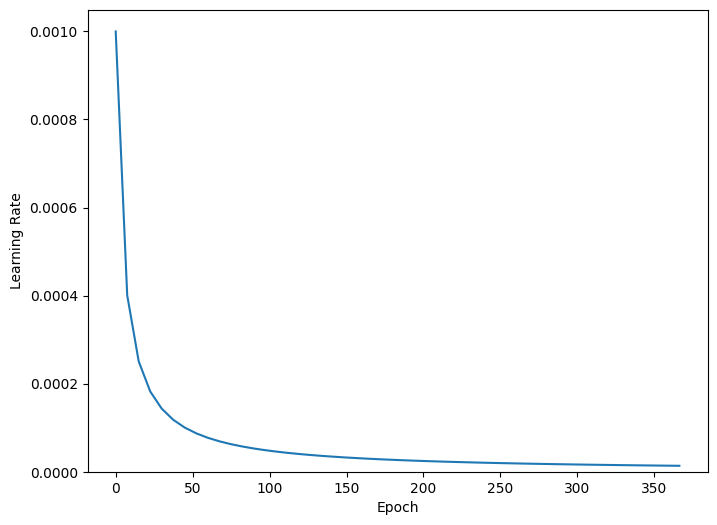

In [9]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

# HyperParameter Tuning
- epoch[0, 0,2, 0,4]

In [24]:
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.0, 0.2, 0.4]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [26]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    # RestNet Layer
    ResNet50V2_layer,
    
    # Flattening the layers
    Flatten(),

    # Adding the dense layer
    Dropout(hparams[HP_DROPOUT]),
    Dense(256, activation='relu'),
    
    Dropout(hparams[HP_DROPOUT]),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax'),
  ])
  model.compile(
    loss='categorical_crossentropy', 
    optimizer = get_optimizer(), 
    metrics = ['accuracy']
  )

  model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=15,
    callbacks=[early_stop],
    verbose = 1
  ) # Run with 1 epoch to speed things up for demo purposes
  _, accuracy = model.evaluate(test_generator)
  return accuracy

In [27]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [28]:
session_num = 0
for dropout_rate in HP_DROPOUT.domain.values:
  hparams = {
    HP_DROPOUT: dropout_rate,
  }
  run_name = "run-%d" % session_num
  print('--- Starting trial: %s' % run_name)
  print({h.name: hparams[h] for h in hparams})
  run('logs/hparam_tuning/' + run_name, hparams)
  session_num += 1

--- Starting trial: run-0
{'dropout': 0.0}
Epoch 1/15
274/274 [==============================] - 268s 880ms/step - loss: 0.4605 - accuracy: 0.8070 - val_loss: 1.3295 - val_accuracy: 0.8190
Epoch 2/15
274/274 [==============================] - 220s 801ms/step - loss: 0.3004 - accuracy: 0.8738 - val_loss: 0.5716 - val_accuracy: 0.8042
Epoch 3/15
274/274 [==============================] - 221s 804ms/step - loss: 0.3506 - accuracy: 0.8607 - val_loss: 185.2091 - val_accuracy: 0.7240
Epoch 4/15
274/274 [==============================] - 221s 805ms/step - loss: 0.3689 - accuracy: 0.8432 - val_loss: 0.5770 - val_accuracy: 0.8338
Epoch 5/15
274/274 [==============================] - 222s 809ms/step - loss: 0.2797 - accuracy: 0.8839 - val_loss: 0.3239 - val_accuracy: 0.8398
Epoch 6/15
274/274 [==============================] - 220s 802ms/step - loss: 0.2429 - accuracy: 0.9029 - val_loss: 0.2726 - val_accuracy: 0.8961
Epoch 7/15
274/274 [==============================] - 221s 805ms/step - loss: 0

Visualisasikan hasilnya di plugin HParams TensorBoard
Dasbor HParams sekarang dapat dibuka. Mulai TensorBoard dan klik "HParams" di bagian atas.
Total HyperParameter tuning time: 169m 15.8s

In [29]:
%tensorboard --logdir logs/hparam_tuning

# model CNN Pretrained model
- with RestNet

In [6]:
cancer_model = Sequential([
  # RestNet Layer
  ResNet50V2_layer,
  
  # Flattening the layers
  Flatten(),

  # Adding the dense layer
  Dense(256, activation='relu'),
  # Dropout...
  Dense(128, activation='relu'),
  Dense(2, activation='softmax'),
])

# cancer_model.layers[0].trainable = False
cancer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 31,986,818
Trainable params: 31,403,138
Non-trainable params: 583,680
_________________________________________________________________


In [17]:
# Compiling the model
cancer_model.compile(
  loss='categorical_crossentropy', 
  optimizer = get_optimizer(), 
  metrics = ['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [10]:
# Model is fitted using train and validation generator for 200 epochs
import time

start_time = time.time()

history = cancer_model.fit(
  train_generator, 
  validation_data=val_generator, 
  epochs=200 ,
  callbacks=[early_stop],
  verbose = 1
  )

Epoch 1/200
274/274 [==============================] - 251s 839ms/step - loss: 0.4242 - accuracy: 0.8287 - val_loss: 0.6344 - val_accuracy: 0.8546
Epoch 2/200
274/274 [==============================] - 229s 834ms/step - loss: 0.3101 - accuracy: 0.8747 - val_loss: 0.4628 - val_accuracy: 0.8249
Epoch 3/200
274/274 [==============================] - 226s 823ms/step - loss: 0.3710 - accuracy: 0.8468 - val_loss: 1.5019 - val_accuracy: 0.6825
Epoch 4/200
274/274 [==============================] - 224s 816ms/step - loss: 0.2880 - accuracy: 0.8788 - val_loss: 0.3086 - val_accuracy: 0.8694
Epoch 5/200
274/274 [==============================] - 224s 817ms/step - loss: 0.2236 - accuracy: 0.9063 - val_loss: 0.2638 - val_accuracy: 0.8961
Epoch 6/200
274/274 [==============================] - 224s 817ms/step - loss: 0.1876 - accuracy: 0.9252 - val_loss: 0.2394 - val_accuracy: 0.9169
Epoch 7/200
274/274 [==============================] - 224s 817ms/step - loss: 0.1997 - accuracy: 0.9253 - val_loss: 0

In [11]:
end_time = time.time()
print("The time of execution of above program is :",(end_time-start_time) * 10**3, "ms")

The time of execution of above program is : 2743467.7612781525 ms


In [12]:
Total_time_second= end_time-start_time
convert_minute = (Total_time_second) // 60
modulo_second = (Total_time_second) % 60
print("total time run : {} Minutes, {} Seconds".format(convert_minute, modulo_second) )

total time run : 45.0 Minutes, 43.467761278152466 Seconds


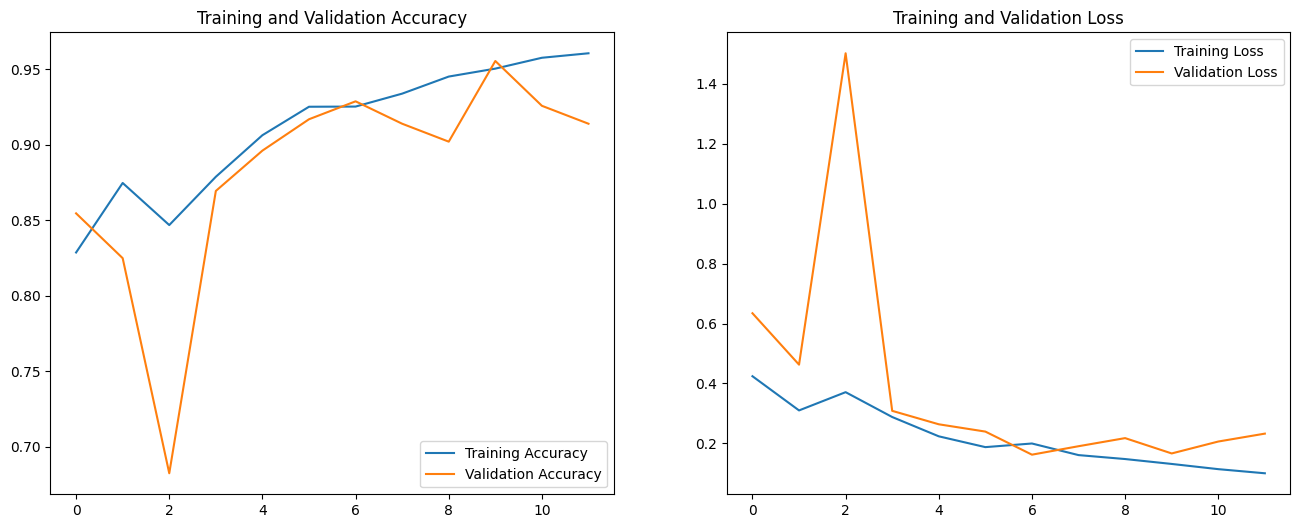

In [14]:
# Plotting the model results

# Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

# No of epochs it trained
epochs_range = history.epoch

# Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
pred = cancer_model.evaluate(test_generator)

38/38 [==============================] - 27s 704ms/step - loss: 0.1702 - accuracy: 0.9419


In [ ]:
# os.mkdir("../src/output/restnet")

In [16]:
cancer_model.save(filepath="../src/output/restnet/restnet50v2_model__HP_fineTune_FIX-v2.h5")

# Load model and model evaluation

In [34]:
cancer_model.load_weights(filepath="../src/output/restnet/restnet50v2_model__HP_fineTune_FIX-v2.h5")

## test load model

In [33]:
loss, acc = cancer_model.evaluate(test_generator, verbose=1)

38/38 [==============================] - 22s 558ms/step - loss: 0.1710 - accuracy: 0.9444


In [36]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

pred = cancer_model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

print("==== Confusion Mtrix ====")
print(confusion_matrix(test_generator.classes, y_pred))

38/38 [==============================] - 19s 502ms/step
==== Confusion Mtrix ====
[[355  25]
 [ 50 757]]


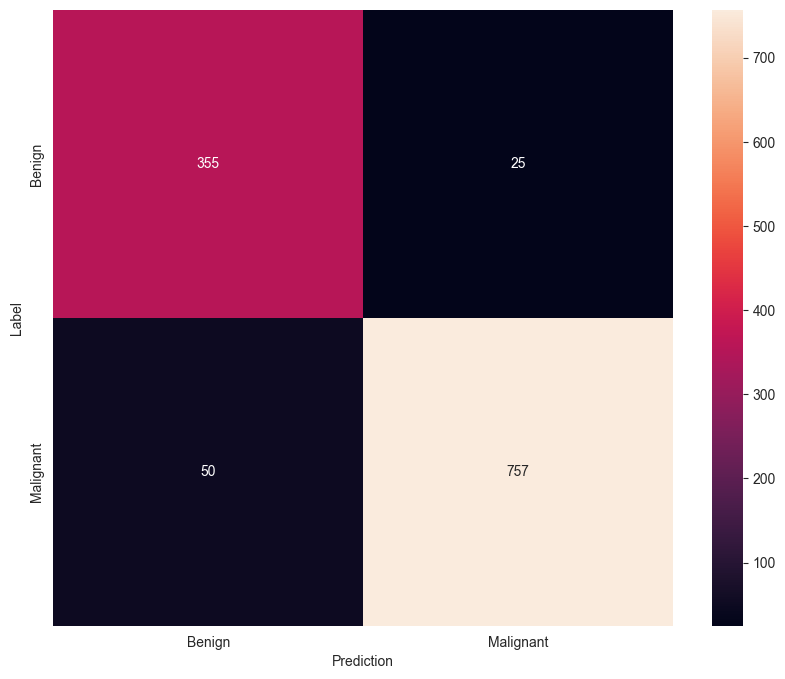

In [37]:
confusion_mtx = tf.math.confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [38]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       380
           1       0.97      0.94      0.95       807

    accuracy                           0.94      1187
   macro avg       0.92      0.94      0.93      1187
weighted avg       0.94      0.94      0.94      1187

